In [ ]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
from io import BytesIO
import torch.nn.functional as F
import random 
import tensorflow as tf
from huggingface_hub import from_pretrained_keras
from huggingface_hub import snapshot_download
from huggingface_hub import login

c:\Users\gabri\OneDrive\Documentos\WoundsDataset\venv_wound\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


huggingface-cli login

In [2]:
from tqdm import tqdm

In [ ]:
# --- 1. Configurações Globais ---
data_dir = os.getcwd()
target_classes_full = ['Diabetic Wounds', 'Normal', 'Pressure Wounds', 'Venous Wounds']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

label_to_idx_full = {name: i for i, name in enumerate(target_classes_full)}
idx_to_label_full = {i: name for i, name in enumerate(target_classes_full)}

# --- 2. Login e carregamento do Derm Foundation ---
local_model_path = snapshot_download("google/derm-foundation")
loaded_derm_foundation_layer = tf.keras.layers.TFSMLayer(
    local_model_path, call_endpoint='serving_default'
)

# Inferência de teste para obter dimensão do embedding
dummy = Image.new('RGB', (224,224))
buf = BytesIO(); dummy.save(buf,'PNG')
ex = tf.train.Example(features=tf.train.Features(
    feature={'image/encoded': tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[buf.getvalue()]))
    })).SerializeToString()
out = loaded_derm_foundation_layer(inputs=tf.constant([ex], dtype=tf.string))
Derm_FOUNDATION_EMBEDDING_SIZE = out['embedding'][0].shape[-1]


def get_derm_embedding(path):
    try:
        img = Image.open(path).convert('RGB')
        buf = BytesIO(); img.save(buf,'PNG')
        ex = tf.train.Example(features=tf.train.Features(
            feature={'image/encoded': tf.train.Feature(
                bytes_list=tf.train.BytesList(value=[buf.getvalue()]))
            })).SerializeToString()
        out = loaded_derm_foundation_layer(inputs=tf.constant([ex], dtype=tf.string))
        emb = out['embedding'][0].numpy()
        return torch.from_numpy(emb).float()
    except:
        return None


# --- 3. Criar DataFrame e splits ---
def create_dataframe(data_dir, classes):
    rows = []
    if not os.path.isdir(data_dir):
        print(f"Erro: Diretório de dados não encontrado: {data_dir}")
        return pd.DataFrame(rows) 
    for cls in classes:
        class_path = os.path.join(data_dir, cls)
        if not os.path.isdir(class_path):
            print(f"Atenção: Diretório da classe não encontrado: {class_path}")
            continue 

        for f in os.listdir(class_path):
            if f.lower().endswith(('png','jpg','jpeg')):
                rows.append({
                    'image_path': os.path.join(class_path, f),
                    'label_name': cls
                })
    df = pd.DataFrame(rows)
    if df.empty:
        print("DataFrame vazio. Verifique se 'data_dir' está correto e contém as imagens nas subpastas de classe.")
        return df 

    df['label_idx'] = df['label_name'].map(label_to_idx_full)
    return df

print(f"Criando DataFrame a partir de: {data_dir}")
df_full = create_dataframe(data_dir, target_classes_full)

if df_full.empty:
    print("Nenhuma imagem encontrada ou erro ao criar DataFrame. Verifique a estrutura de diretórios e os caminhos.")
    exit()

print(f"Total de imagens encontradas (incluindo 'Normal'): {len(df_full)}")
print(f"Contagem de imagens por classe (incluindo 'Normal'):\n{df_full['label_name'].value_counts()}")


# Estágio 2: apenas feridas
df_s2 = df_full[df_full['label_name']!='Normal'].copy()
if df_s2.empty:
    print("Nenhuma imagem de ferida encontrada após excluir a classe 'Normal'.")
    exit()

print(f"\nTotal de imagens de feridas antes da filtragem de 'mirrored_': {len(df_s2)}")

mask_not_mirrored = ~df_s2['image_path'].str.contains('mirrored_')

df_s2_filtered = df_s2[mask_not_mirrored].copy()

print(f"Total de imagens de feridas após a filtragem de 'mirrored_': {len(df_s2_filtered)}")
print(f"Número de imagens 'mirrored_' removidas: {len(df_s2) - len(df_s2_filtered)}")


s2_map = {l:i for i,l in enumerate(sorted(df_s2_filtered['label_name'].unique()))}
df_s2_filtered['label_s2'] = df_s2_filtered['label_name'].map(s2_map)
classes_s2 = list(s2_map.keys()) 
idx_to_label_s2 = {v: k for k, v in s2_map.items()} 

print(f"\nClasses para o Estágio 2 (tipos de ferida) após filtragem: {classes_s2}")
print(f"Mapeamento de rótulos para o Estágio 2 após filtragem: {s2_map}")

train_df_s2, test_df_s2 = train_test_split(df_s2_filtered, test_size=0.2,
                                         stratify=df_s2_filtered['label_s2'], random_state=42)
train_df_s2, val_df_s2 = train_test_split(train_df_s2, test_size=0.2,
                                         stratify=train_df_s2['label_s2'], random_state=42)

print(f"\nTamanho do conjunto de treino (Estágio 2) após filtragem: {len(train_df_s2)}")
print(f"Tamanho do conjunto de validação (Estágio 2) após filtragem: {len(val_df_s2)}")
print(f"Tamanho do conjunto de teste (Estágio 2) após filtragem: {len(test_df_s2)}")

Fetching 7 files: 100%|██████████| 7/7 [00:00<?, ?it/s]


Criando DataFrame a partir de: c:\Users\gabri\OneDrive\Documentos\WoundsDataset
Total de imagens encontradas (incluindo 'Normal'): 1758
Contagem de imagens por classe (incluindo 'Normal'):
label_name
Pressure Wounds    602
Venous Wounds      494
Diabetic Wounds    462
Normal             200
Name: count, dtype: int64

Total de imagens de feridas antes da filtragem de 'mirrored_': 1558
Total de imagens de feridas após a filtragem de 'mirrored_': 779
Número de imagens 'mirrored_' removidas: 779

Classes para o Estágio 2 (tipos de ferida) após filtragem: ['Diabetic Wounds', 'Pressure Wounds', 'Venous Wounds']
Mapeamento de rótulos para o Estágio 2 após filtragem: {'Diabetic Wounds': 0, 'Pressure Wounds': 1, 'Venous Wounds': 2}

Tamanho do conjunto de treino (Estágio 2) após filtragem: 498
Tamanho do conjunto de validação (Estágio 2) após filtragem: 125
Tamanho do conjunto de teste (Estágio 2) após filtragem: 156


In [ ]:
# --- 4. Pré-computar embeddings offline ---
def precompute_embeddings(df, split, outdir="embeddings"):
    os.makedirs(outdir, exist_ok=True)
    embs, labels = [], []
    for _, r in tqdm(df.iterrows(), total=len(df), desc=f"Precompute {split}"):
        e = get_derm_embedding(r['image_path'])
        if e is not None:
            embs.append(e)
            labels.append(int(r['label_s2']))
    embs_t  = torch.stack(embs)
    labs_t  = torch.tensor(labels)
    path = os.path.join(outdir, f"{split}_emb.pt")
    torch.save((embs_t, labs_t), path)
    return path

train_s2_path = precompute_embeddings(train_df_s2, "train_s2")
val_s2_path   = precompute_embeddings(val_df_s2,   "val_s2")
test_s2_path  = precompute_embeddings(test_df_s2,  "test_s2")

# --- 5. Dataset e DataLoader de embeddings ---
class PrecomputedEmbeddingDataset(Dataset):
    def __init__(self, emb_path):
        self.embs, self.labels = torch.load(emb_path)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return self.embs[idx], self.labels[idx]

batch_size = 32
train_loader_s2_emb = DataLoader(PrecomputedEmbeddingDataset(train_s2_path),
                                 batch_size, shuffle=True)
val_loader_s2_emb = DataLoader(PrecomputedEmbeddingDataset(val_s2_path),
                               batch_size, shuffle=False)
test_loader_s2_emb = DataLoader(PrecomputedEmbeddingDataset(test_s2_path),
                                batch_size, shuffle=False)

Fetching 7 files: 100%|██████████| 7/7 [00:00<?, ?it/s]


Criando DataFrame a partir de: c:\Users\gabri\OneDrive\Documentos\WoundsDataset
Total de imagens encontradas (incluindo 'Normal'): 1758
Contagem de imagens por classe (incluindo 'Normal'):
label_name
Pressure Wounds    602
Venous Wounds      494
Diabetic Wounds    462
Normal             200
Name: count, dtype: int64

Total de imagens de feridas antes da filtragem de 'mirrored_': 1558
Total de imagens de feridas após a filtragem de 'mirrored_': 779
Número de imagens 'mirrored_' removidas: 779

Classes para o Estágio 2 (tipos de ferida) após filtragem: ['Diabetic Wounds', 'Pressure Wounds', 'Venous Wounds']
Mapeamento de rótulos para o Estágio 2 após filtragem: {'Diabetic Wounds': 0, 'Pressure Wounds': 1, 'Venous Wounds': 2}

Tamanho do conjunto de treino (Estágio 2) após filtragem: 498
Tamanho do conjunto de validação (Estágio 2) após filtragem: 125
Tamanho do conjunto de teste (Estágio 2) após filtragem: 156


Precompute test_s2: 100%|██████████| 156/156 [07:55<00:00,  3.05s/it]



--- Treino Estágio 2 (Feridas) ---


Epoch 1 Train Loss: 0.6361 Acc: 0.7309


Epoch 1 Val   Loss: 0.5366 Acc: 0.7760
→ Salvo melhor modelo (0.7760) em modelo_estagio2_derm_emb.pth


Epoch 2 Train Loss: 0.4498 Acc: 0.8133


Epoch 2 Val   Loss: 0.4607 Acc: 0.7920
→ Salvo melhor modelo (0.7920) em modelo_estagio2_derm_emb.pth


Epoch 3 Train Loss: 0.3509 Acc: 0.8735


Epoch 3 Val   Loss: 0.4221 Acc: 0.8240
→ Salvo melhor modelo (0.8240) em modelo_estagio2_derm_emb.pth


Epoch 4 Train Loss: 0.2977 Acc: 0.8916


Epoch 4 Val   Loss: 0.4786 Acc: 0.8000


Epoch 5 Train Loss: 0.2777 Acc: 0.9016


Epoch 5 Val   Loss: 0.4554 Acc: 0.8080


Epoch 6 Train Loss: 0.2488 Acc: 0.9096


Epoch 6 Val   Loss: 0.4288 Acc: 0.8240


Epoch 7 Train Loss: 0.2234 Acc: 0.9217


Epoch 7 Val   Loss: 0.4191 Acc: 0.8400
→ Salvo melhor modelo (0.8400) em modelo_estagio2_derm_emb.pth


Epoch 8 Train Loss: 0.2191 Acc: 0.9257


Epoch 8 Val   Loss: 0.4797 Acc: 0.8160


Epoch 9 Train Loss: 0.2005 Acc: 0.9317


Epoch 9 Val   Loss: 0.4297 Acc: 0.8400


Epoch 10 Train Loss: 0.1789 Acc: 0.9337


Epoch 10 Val   Loss: 0.4284 Acc: 0.8320


In [5]:
# --- 6. Definição do classificador e funções de treino/validação ---
def get_classifier_head(emb_size, n_classes):
    return nn.Linear(emb_size, n_classes).to(device)

def train_epoch(model, loader, crit, opt, epoch, epochs):
    model.train(); rl, rc, tot = 0, 0, 0
    for emb, lbl in tqdm(loader, desc=f"Train {epoch+1}/{epochs}", leave=False):
        emb, lbl = emb.to(device), lbl.to(device)
        opt.zero_grad()
        out = model(emb)
        loss = crit(out, lbl)
        loss.backward()
        opt.step()
        rl += loss.item()*emb.size(0)
        preds = out.argmax(1)
        rc += (preds==lbl).sum().item()
        tot+= lbl.size(0)
    print(f"Epoch {epoch+1} Train Loss: {rl/tot:.4f} Acc: {rc/tot:.4f}")
    return rl/tot, rc/tot

def val_epoch(model, loader, crit, epoch, epochs):
    model.eval(); rl, rc, tot = 0, 0, 0
    with torch.no_grad():
        for emb, lbl in tqdm(loader, desc=f"Val   {epoch+1}/{epochs}", leave=False):
            emb, lbl = emb.to(device), lbl.to(device)
            out  = model(emb)
            loss = crit(out, lbl)
            rl += loss.item()*emb.size(0)
            preds = out.argmax(1)
            rc += (preds==lbl).sum().item()
            tot+= lbl.size(0)
    print(f"Epoch {epoch+1} Val   Loss: {rl/tot:.4f} Acc: {rc/tot:.4f}")
    return rl/tot, rc/tot

def run_training_emb(model, tr_loader, v_loader, crit, opt, save_path, epochs=10):
    best_acc=0
    for e in range(epochs):
        train_epoch(model, tr_loader, crit, opt, e, epochs)
        _, acc = val_epoch(model, v_loader, crit, e, epochs)
        if acc>best_acc:
            best_acc=acc
            torch.save(model.state_dict(), save_path)
            print(f"→ Salvo melhor modelo ({acc:.4f}) em {save_path}")

In [21]:
# --- 5. Dataset e DataLoader de embeddings ---
class PrecomputedEmbeddingDataset(Dataset):
    def __init__(self, emb_path):
        self.embs, self.labels = torch.load(emb_path)
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx):
        return self.embs[idx], self.labels[idx]

batch_size = 32
train_loader_s2_emb = DataLoader(PrecomputedEmbeddingDataset(train_s2_path),
                                 batch_size, shuffle=True)
val_loader_s2_emb = DataLoader(PrecomputedEmbeddingDataset(val_s2_path),
                               batch_size, shuffle=False)
test_loader_s2_emb = DataLoader(PrecomputedEmbeddingDataset(test_s2_path),
                                batch_size, shuffle=False)

In [13]:
# --- 7. Treinamento do Estágio 2 ---
print("\n--- Treino Estágio 2 (Feridas) ---")
model_s2 = get_classifier_head(Derm_FOUNDATION_EMBEDDING_SIZE, len(classes_s2))
crit_s2 = nn.CrossEntropyLoss()
opt_s2  = optim.AdamW(model_s2.parameters(), lr=1e-3, weight_decay=0.01)

run_training_emb(model_s2,
                 train_loader_s2_emb,
                 val_loader_s2_emb,
                 crit_s2,
                 opt_s2,
                 "modelo_estagio2_derm_emb.pth",
                 epochs=50)


--- Treino Estágio 2 (Feridas) ---


Epoch 1 Train Loss: 0.7514 Acc: 0.6747


Epoch 1 Val   Loss: 0.5314 Acc: 0.7920
→ Salvo melhor modelo (0.7920) em modelo_estagio2_derm_emb.pth


Epoch 2 Train Loss: 0.4411 Acc: 0.8233


Epoch 2 Val   Loss: 0.4900 Acc: 0.8160
→ Salvo melhor modelo (0.8160) em modelo_estagio2_derm_emb.pth


Epoch 3 Train Loss: 0.3661 Acc: 0.8494


Epoch 3 Val   Loss: 0.4932 Acc: 0.7680


Epoch 4 Train Loss: 0.3338 Acc: 0.8775


Epoch 4 Val   Loss: 0.4338 Acc: 0.8160


Epoch 5 Train Loss: 0.2875 Acc: 0.8996


Epoch 5 Val   Loss: 0.4279 Acc: 0.8160


Epoch 6 Train Loss: 0.2715 Acc: 0.8936


Epoch 6 Val   Loss: 0.4670 Acc: 0.8080


Epoch 7 Train Loss: 0.2324 Acc: 0.9177


Epoch 7 Val   Loss: 0.5155 Acc: 0.7680


Epoch 8 Train Loss: 0.2270 Acc: 0.9197


Epoch 8 Val   Loss: 0.4407 Acc: 0.8400
→ Salvo melhor modelo (0.8400) em modelo_estagio2_derm_emb.pth


Epoch 9 Train Loss: 0.2100 Acc: 0.9177


Epoch 9 Val   Loss: 0.4395 Acc: 0.8400


Epoch 10 Train Loss: 0.2049 Acc: 0.9277


Epoch 10 Val   Loss: 0.4346 Acc: 0.8320


Epoch 11 Train Loss: 0.1720 Acc: 0.9438


Epoch 11 Val   Loss: 0.4552 Acc: 0.8000


Epoch 12 Train Loss: 0.1565 Acc: 0.9558


Epoch 12 Val   Loss: 0.4404 Acc: 0.8480
→ Salvo melhor modelo (0.8480) em modelo_estagio2_derm_emb.pth


Epoch 13 Train Loss: 0.1424 Acc: 0.9719


Epoch 13 Val   Loss: 0.4456 Acc: 0.8400


Epoch 14 Train Loss: 0.1249 Acc: 0.9779


Epoch 14 Val   Loss: 0.4448 Acc: 0.8400


Epoch 15 Train Loss: 0.1261 Acc: 0.9679


Epoch 15 Val   Loss: 0.4514 Acc: 0.8320


Epoch 16 Train Loss: 0.1259 Acc: 0.9719


Epoch 16 Val   Loss: 0.4541 Acc: 0.8320


Epoch 17 Train Loss: 0.1199 Acc: 0.9779


Epoch 17 Val   Loss: 0.5411 Acc: 0.7920


Epoch 18 Train Loss: 0.1061 Acc: 0.9799


Epoch 18 Val   Loss: 0.4796 Acc: 0.8320


Epoch 19 Train Loss: 0.1097 Acc: 0.9759


Epoch 19 Val   Loss: 0.5215 Acc: 0.7760


Epoch 20 Train Loss: 0.1034 Acc: 0.9699


Epoch 20 Val   Loss: 0.4892 Acc: 0.8240


Epoch 21 Train Loss: 0.0834 Acc: 0.9920


Epoch 21 Val   Loss: 0.4717 Acc: 0.8480


Epoch 22 Train Loss: 0.0809 Acc: 0.9920


Epoch 22 Val   Loss: 0.4691 Acc: 0.8400


Epoch 23 Train Loss: 0.0777 Acc: 0.9980


Epoch 23 Val   Loss: 0.4803 Acc: 0.8400


Epoch 24 Train Loss: 0.0777 Acc: 0.9880


Epoch 24 Val   Loss: 0.4820 Acc: 0.8400


Epoch 25 Train Loss: 0.0699 Acc: 0.9940


Epoch 25 Val   Loss: 0.4949 Acc: 0.8320


Epoch 26 Train Loss: 0.0638 Acc: 0.9960


Epoch 26 Val   Loss: 0.4834 Acc: 0.8240


Epoch 27 Train Loss: 0.0632 Acc: 0.9900


Epoch 27 Val   Loss: 0.4923 Acc: 0.8320


Epoch 28 Train Loss: 0.0581 Acc: 0.9960


Epoch 28 Val   Loss: 0.4949 Acc: 0.8400


Epoch 29 Train Loss: 0.0558 Acc: 1.0000


Epoch 29 Val   Loss: 0.4922 Acc: 0.8560
→ Salvo melhor modelo (0.8560) em modelo_estagio2_derm_emb.pth


Epoch 30 Train Loss: 0.0509 Acc: 1.0000


Epoch 30 Val   Loss: 0.5010 Acc: 0.8320


Epoch 31 Train Loss: 0.0490 Acc: 1.0000


Epoch 31 Val   Loss: 0.4919 Acc: 0.8400


Epoch 32 Train Loss: 0.0477 Acc: 1.0000


Epoch 32 Val   Loss: 0.5217 Acc: 0.8080


Epoch 33 Train Loss: 0.0461 Acc: 0.9980


Epoch 33 Val   Loss: 0.5187 Acc: 0.8000


Epoch 34 Train Loss: 0.0455 Acc: 1.0000


Epoch 34 Val   Loss: 0.5233 Acc: 0.8400


Epoch 35 Train Loss: 0.0433 Acc: 1.0000


Epoch 35 Val   Loss: 0.5122 Acc: 0.8560


Epoch 36 Train Loss: 0.0432 Acc: 1.0000


Epoch 36 Val   Loss: 0.5183 Acc: 0.8400


Epoch 37 Train Loss: 0.0395 Acc: 1.0000


Epoch 37 Val   Loss: 0.5260 Acc: 0.8400


Epoch 38 Train Loss: 0.0379 Acc: 1.0000


Epoch 38 Val   Loss: 0.5256 Acc: 0.8400


Epoch 39 Train Loss: 0.0360 Acc: 1.0000


Epoch 39 Val   Loss: 0.5308 Acc: 0.8320


Epoch 40 Train Loss: 0.0342 Acc: 1.0000


Epoch 40 Val   Loss: 0.5572 Acc: 0.7840


Epoch 41 Train Loss: 0.0349 Acc: 0.9980


Epoch 41 Val   Loss: 0.5472 Acc: 0.8240


Epoch 42 Train Loss: 0.0323 Acc: 1.0000


Epoch 42 Val   Loss: 0.5327 Acc: 0.8480


Epoch 43 Train Loss: 0.0331 Acc: 1.0000


Epoch 43 Val   Loss: 0.5349 Acc: 0.8480


Epoch 44 Train Loss: 0.0320 Acc: 1.0000


Epoch 44 Val   Loss: 0.5532 Acc: 0.8400


Epoch 45 Train Loss: 0.0294 Acc: 1.0000


Epoch 45 Val   Loss: 0.5369 Acc: 0.8480


Epoch 46 Train Loss: 0.0304 Acc: 1.0000


Epoch 46 Val   Loss: 0.5705 Acc: 0.8080


Epoch 47 Train Loss: 0.0291 Acc: 1.0000


Epoch 47 Val   Loss: 0.5630 Acc: 0.8080


Epoch 48 Train Loss: 0.0262 Acc: 1.0000


Epoch 48 Val   Loss: 0.5633 Acc: 0.8320


Epoch 49 Train Loss: 0.0257 Acc: 1.0000


Epoch 49 Val   Loss: 0.5513 Acc: 0.8480


Epoch 50 Train Loss: 0.0244 Acc: 1.0000


Epoch 50 Val   Loss: 0.5622 Acc: 0.8320


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

In [20]:
train_s2_path = "embeddings/train_s2_emb.pt"
val_s2_path = "embeddings/val_s2_emb.pt"
test_s2_path = "embeddings/test_s2_emb.pt"

In [23]:
model_s2 = get_classifier_head(Derm_FOUNDATION_EMBEDDING_SIZE, len(classes_s2))


--- Avaliação Detalhada no Conjunto de Teste (Estágio 2) ---
Coletando predições para o conjunto de teste...



Relatório de Classificação - Conjunto de Teste:
                 precision    recall  f1-score   support

Diabetic Wounds       0.78      0.76      0.77        46
Pressure Wounds       0.91      0.82      0.86        60
  Venous Wounds       0.84      0.96      0.90        50

       accuracy                           0.85       156
      macro avg       0.84      0.85      0.84       156
   weighted avg       0.85      0.85      0.85       156


Acurácia Geral no Conjunto de Teste: 0.8462

Métricas Gerais do Modelo (Weighted Average):
  Precision: 0.8483
  Recall: 0.8462
  F1-score: 0.8450


  AUC (Weighted) do Modelo: 0.9601

Calculando Matriz de Confusão...
Visualizando Matriz de Confusão (em %)...


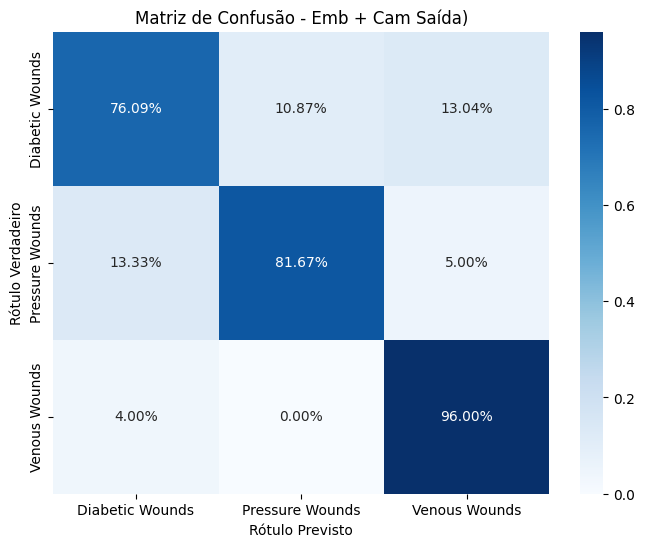


Classes do Estágio 2 e seus índices para referência:
Índice 0: Diabetic Wounds
Índice 1: Pressure Wounds
Índice 2: Venous Wounds


In [ ]:
from sklearn.metrics import roc_auc_score
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import os
from tqdm import tqdm

# --- 8. Avaliação Detalhada no Conjunto de Teste ---
print("\n--- Avaliação Detalhada no Conjunto de Teste (Estágio 2) ---")

save_model_path = "modelo_estagio2_derm_emb.pth"

if 'test_loader_s2_emb' not in globals() or test_loader_s2_emb is None or len(test_loader_s2_emb.dataset) == 0:
    print("Loader de teste não disponível ou vazio. Pulando avaliação detalhada.")
else:
    if not os.path.exists(save_model_path):
        print(f"Modelo treinado '{save_model_path}' não encontrado. Não é possível carregar para avaliação.")
    else:
        model_s2.load_state_dict(torch.load(save_model_path, map_location=device))
        model_s2.eval()

        all_labels = []
        all_preds = []
        all_probs = []

        print("Coletando predições para o conjunto de teste...")
        with torch.no_grad():
            for emb, lbl in tqdm(test_loader_s2_emb, desc="Avaliando Teste", leave=False):
                emb, lbl = emb.to(device), lbl.to(device)

                out = model_s2(emb)
                probs = F.softmax(out, dim=1)
                preds = out.argmax(1)

                all_labels.extend(lbl.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())

        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_probs = np.array(all_probs)

        # --- Geração e Exibição das Métricas de Avaliação ---
        print("\nRelatório de Classificação - Conjunto de Teste:")
        report_dict = classification_report(all_labels, all_preds, target_names=classes_s2, output_dict=True, zero_division=0)
        print(classification_report(all_labels, all_preds, target_names=classes_s2, zero_division=0))

        overall_test_accuracy = accuracy_score(all_labels, all_preds)
        print(f"\nAcurácia Geral no Conjunto de Teste: {overall_test_accuracy:.4f}")

        print("\nMétricas Gerais do Modelo (Weighted Average):")
        print(f"   Precision: {report_dict['weighted avg']['precision']:.4f}")
        print(f"   Recall: {report_dict['weighted avg']['recall']:.4f}")
        print(f"   F1-score: {report_dict['weighted avg']['f1-score']:.4f}")

        if len(np.unique(all_labels)) > 1:
            try:
                auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='weighted')
                print(f"   AUC (Weighted) do Modelo: {auc_score:.4f}")
            except ValueError as e:
                print(f"   Não foi possível calcular o AUC: {e}. Isso pode ocorrer se houver apenas uma classe verdadeira nos dados.")
        else:
            print("   Não foi possível calcular o AUC: Apenas uma classe verdadeira encontrada nos dados.")

        print("\nCalculando Matriz de Confusão...")
        cm = confusion_matrix(all_labels, all_preds, labels=range(len(classes_s2)))

        row_sums = cm.sum(axis=1)[:, np.newaxis]
        cm_normalized = np.where(row_sums > 0, cm.astype('float') / row_sums, 0)

        print("Visualizando Matriz de Confusão (em %)...")
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', xticklabels=classes_s2, yticklabels=classes_s2)
        plt.xlabel('Rótulo Previsto')
        plt.ylabel('Rótulo Verdadeiro')
        plt.title('Matriz de Confusão - Emb + Cam Saída)')
        plt.show()

print(f"\nClasses do Estágio 2 e seus índices para referência:")
if 'idx_to_label_s2' in locals():
     for i, name in idx_to_label_s2.items():
         print(f"Índice {i}: {name}")
else:
     print("Mapeamento de índices para nomes de classes (Estágio 2):")
     for i, name in enumerate(classes_s2):
         print(f"Índice {i}: {name}")


--- Avaliação Detalhada no Conjunto de Teste (Estágio 2) ---
Avaliando apenas predições com confiança (probabilidade máxima) > 0.99
Coletando predições e probabilidades para o conjunto de teste...



Total de amostras no conjunto de teste: 156
Total de amostras com confiança > 0.99: 132

--- Resultados para Predições com Confiança > 0.99 ---

Relatório de Classificação - Conjunto de Teste (Filtrado):
                 precision    recall  f1-score   support

Diabetic Wounds       0.82      0.84      0.83        38
Pressure Wounds       0.98      0.84      0.90        50
  Venous Wounds       0.88      1.00      0.94        44

       accuracy                           0.89       132
      macro avg       0.89      0.89      0.89       132
   weighted avg       0.90      0.89      0.89       132


Acurácia Geral para Predições com Confiança > 0.99: 0.8939

Calculando Matriz de Confusão (Filtrada)...
Visualizando Matriz de Confusão Normalizada (Filtrada, em %)...


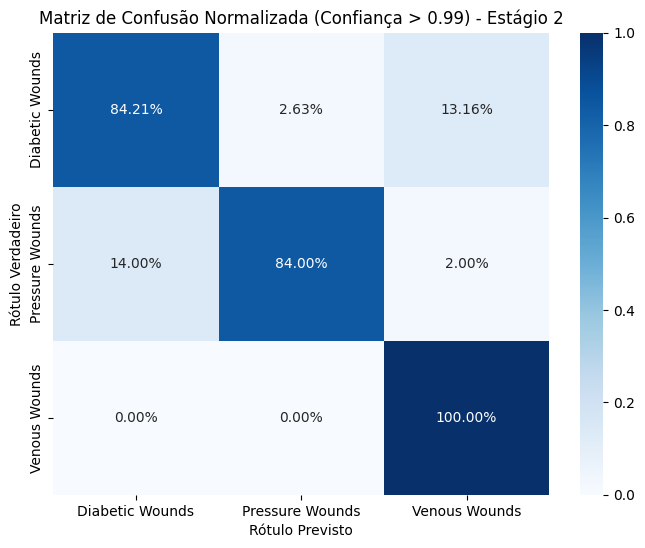


Classes do Estágio 2 e seus índices para referência:
Índice 0: Diabetic Wounds
Índice 1: Pressure Wounds
Índice 2: Venous Wounds


In [ ]:
# --- 8. Avaliação Detalhada no Conjunto de Teste (Filtrada por Confiança) ---
print("\n--- Avaliação Detalhada no Conjunto de Teste (Estágio 2) ---")

confidence_threshold = 0.95
print(f"Avaliando apenas predições com confiança (probabilidade máxima) > {confidence_threshold:.2f}")

if 'test_loader_s2_emb' not in globals() or test_loader_s2_emb is None or len(test_loader_s2_emb.dataset) == 0:
    print("Loader de teste não disponível ou vazio. Pulando avaliação detalhada.")
else:
    if not os.path.exists(save_model_path):
        print(f"Modelo treinado '{save_model_path}' não encontrado. Não é possível carregar para avaliação.")
    else:
        model_s2.load_state_dict(torch.load(save_model_path))
        model_s2.eval()

        all_labels = []
        all_preds = []
        all_max_probs = []

        print("Coletando predições e probabilidades para o conjunto de teste...")
        with torch.no_grad():
            for emb, lbl in tqdm(test_loader_s2_emb, desc="Avaliando Teste", leave=False):
                emb, lbl = emb.to(device), lbl.to(device)
                
                out = model_s2(emb)
                probabilities = torch.softmax(out, dim=1)
                max_probs, preds = torch.max(probabilities, dim=1) 

                all_labels.extend(lbl.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_max_probs.extend(max_probs.cpu().numpy())

        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_max_probs = np.array(all_max_probs)

        # --- Filtrar predições por limiar de confiança ---
        confident_mask = all_max_probs > confidence_threshold

        filtered_labels = all_labels[confident_mask]
        filtered_preds = all_preds[confident_mask]
        filtered_confidence_scores = all_max_probs[confident_mask]

        print(f"\nTotal de amostras no conjunto de teste: {len(all_labels)}")
        print(f"Total de amostras com confiança > {confidence_threshold:.2f}: {len(filtered_labels)}")

        # --- Geração e Exibição das Métricas de Avaliação (Filtradas) ---
        if len(filtered_labels) == 0:
            print("\nNenhuma predição atingiu o limiar de confiança especificado.")
        else:
            print(f"\n--- Resultados para Predições com Confiança > {confidence_threshold:.2f} ---")

            print("\nRelatório de Classificação - Conjunto de Teste (Filtrado):")
            report_filtered = classification_report(filtered_labels, filtered_preds, target_names=classes_s2, zero_division=0)
            print(report_filtered)

            overall_test_accuracy_filtered = accuracy_score(filtered_labels, filtered_preds)
            print(f"\nAcurácia Geral para Predições com Confiança > {confidence_threshold:.2f}: {overall_test_accuracy_filtered:.4f}")

            print("\nCalculando Matriz de Confusão (Filtrada)...")
            cm_filtered = confusion_matrix(filtered_labels, filtered_preds)

            row_sums_filtered = cm_filtered.sum(axis=1)
            cm_normalized_filtered = cm_filtered.astype('float') / (row_sums_filtered[:, np.newaxis] + 1e-9)

            print("Visualizando Matriz de Confusão Normalizada (Filtrada, em %)...")
            plt.figure(figsize=(8, 6))
            
            sns.heatmap(cm_normalized_filtered, annot=True, fmt='.2%', cmap='Blues', xticklabels=classes_s2, yticklabels=classes_s2)
            
            plt.xlabel('Rótulo Previsto')
            plt.ylabel('Rótulo Verdadeiro')
            plt.title(f'Matriz de Confusão Normalizada (Confiança > {confidence_threshold:.2f}) - Estágio 2')
            plt.show()

print(f"\nClasses do Estágio 2 e seus índices para referência:")
if 'idx_to_label_s2' in locals():
     for i, name in idx_to_label_s2.items():
         print(f"Índice {i}: {name}")
else:
     print("Mapeamento de índices para nomes de classes (Estágio 2):")
     for i, name in enumerate(classes_s2):
         print(f"Índice {i}: {name}")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm

# --- 1. Definição do Novo Modelo Classificador MLP ---

class SimpleMLPClassifier(nn.Module):
    def __init__(self, emb_size, num_classes, hidden_size=256, dropout_rate=0.25):
        super(SimpleMLPClassifier, self).__init__()

        self.fc1 = nn.Linear(emb_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc_out = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        x = self.fc_out(x)
        return x

def get_classifier_head(emb_size, n_classes):
    return SimpleMLPClassifier(emb_size, n_classes).to(device)

# --- 2. Funções de Treinamento e Validação ---

def train_epoch(model, loader, crit, opt, epoch, epochs):
    model.train(); rl, rc, tot = 0, 0, 0
    if loader is None or len(loader.dataset) == 0:
        print(f"Loader de treino vazio na época {epoch+1}. Pulando treino.")
        return 0, 0

    for emb, lbl in tqdm(loader, desc=f"Treino {epoch+1}/{epochs}", leave=False):
        emb, lbl = emb.to(device), lbl.to(device)
        opt.zero_grad()
        out = model(emb)
        loss = crit(out, lbl)
        loss.backward()
        opt.step()
        rl += loss.item()*emb.size(0)
        preds = out.argmax(1)
        rc += (preds==lbl).sum().item()
        tot+= lbl.size(0)
    avg_loss = rl/tot if tot > 0 else 0
    avg_acc = rc/tot if tot > 0 else 0
    print(f"Época {epoch+1} Treino Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}")
    return avg_loss, avg_acc

def val_epoch(model, loader, crit, epoch, epochs, phase="Val"):
    model.eval(); rl, rc, tot = 0, 0, 0
    if loader is None or len(loader.dataset) == 0:
        print(f"Loader de {phase} vazio na época {epoch+1}. Pulando validação/teste.")
        return 0, 0

    with torch.no_grad():
        for emb, lbl in tqdm(loader, desc=f"{phase}  {epoch+1}/{epochs}", leave=False):
            emb, lbl = emb.to(device), lbl.to(device)
            out  = model(emb)
            loss = crit(out, lbl)
            rl += loss.item()*emb.size(0)
            preds = out.argmax(1)
            rc += (preds==lbl).sum().item()
            tot+= lbl.size(0)
    avg_loss = rl/tot if tot > 0 else 0
    avg_acc = rc/tot if tot > 0 else 0
    print(f"Época {epoch+1} {phase}  Loss: {avg_loss:.4f} Acc: {avg_acc:.4f}")
    return avg_loss, avg_acc

def run_training_emb(model, tr_loader, v_loader, crit, opt, save_path, epochs=10):
    best_acc = 0
    if tr_loader is None or v_loader is None or len(tr_loader.dataset) == 0 or len(v_loader.dataset) == 0:
        print("Loaders de treino ou validação não disponíveis ou vazios. Pulando treinamento.")
        return

    print(f"\nIniciando treinamento por {epochs} épocas...")
    for e in range(epochs):
        train_epoch(model, tr_loader, crit, opt, e, epochs)
        _, acc = val_epoch(model, v_loader, crit, e, epochs)
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), save_path)
            print(f"→ Modelo salvo (melhor acc de validação: {acc:.4f}) em {save_path}")

    print(f"Treinamento concluído. Melhor acurácia de validação: {best_acc:.4f}")
    print(f"Modelo final salvo em: {save_path}")


--- Avaliação Detalhada no Conjunto de Teste (Estágio 2 MLP) ---
Coletando predições e probabilidades para o conjunto de teste...



--- Resultados para TODAS as Predições (MLP) ---

Relatório de Classificação - Conjunto de Teste (Não Filtrado):
                 precision    recall  f1-score   support

Diabetic Wounds       0.79      0.72      0.75        46
Pressure Wounds       0.82      0.85      0.84        60
  Venous Wounds       0.88      0.92      0.90        50

       accuracy                           0.83       156
      macro avg       0.83      0.83      0.83       156
   weighted avg       0.83      0.83      0.83       156


Acurácia Geral (Não Filtrada): 0.8333

Métricas Gerais (Weighted Average - Não Filtrado):
  Precision: 0.8316
  Recall: 0.8333
  F1-score: 0.8318
  AUC (Weighted - Não Filtrado) do Modelo: 0.9480
Visualizando Matriz de Confusão Normalizada (Não Filtrada, em %)...


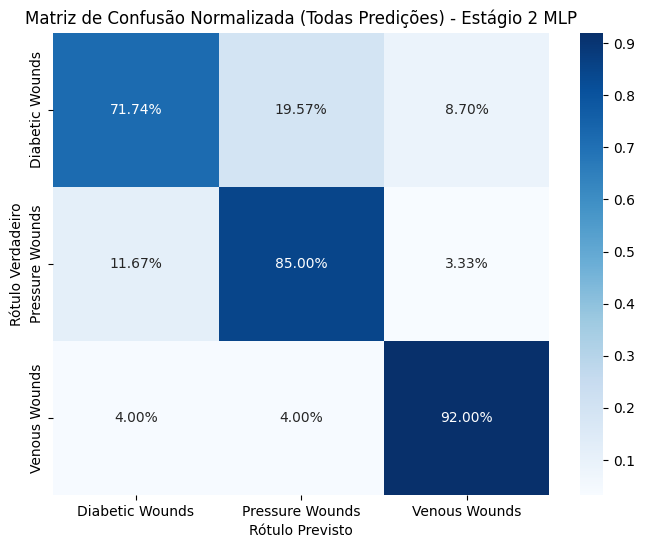


--- Resultados para Predições com Confiança > 0.99 (MLP) ---

Total de amostras no conjunto de teste: 156
Total de amostras com confiança > 0.99: 131

Relatório de Classificação - Conjunto de Teste (Filtrado):
                 precision    recall  f1-score   support

Diabetic Wounds       0.83      0.81      0.82        36
Pressure Wounds       0.92      0.88      0.90        52
  Venous Wounds       0.89      0.95      0.92        43

       accuracy                           0.89       131
      macro avg       0.88      0.88      0.88       131
   weighted avg       0.89      0.89      0.88       131


Acurácia Geral para Predições com Confiança > 0.99: 0.8855

Métricas Gerais (Weighted Average - Filtrado):
  Precision: 0.8855
  Recall: 0.8855
  F1-score: 0.8849
  AUC (Weighted - Filtrado) do Modelo: 0.9660
Visualizando Matriz de Confusão Normalizada (Filtrada, em %)...


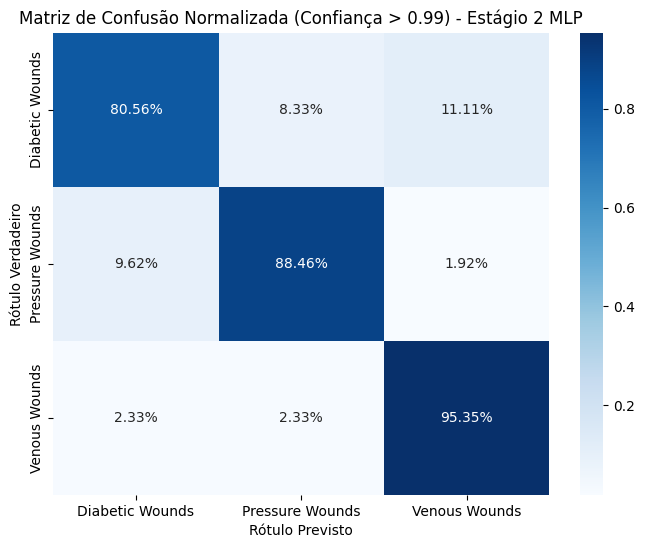


Classes do Estágio 2 e seus índices para referência:
Índice 0: Diabetic Wounds
Índice 1: Pressure Wounds
Índice 2: Venous Wounds


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from tqdm import tqdm

# --- 4. Avaliação Detalhada no Conjunto de Teste (Para o modelo MLP) ---
print("\n--- Avaliação Detalhada no Conjunto de Teste (Estágio 2 MLP) ---")

save_model_path_mlp = "modelo_estagio2_mlp_derm_emb.pth"

if 'test_loader_s2_emb' not in globals() or test_loader_s2_emb is None or len(test_loader_s2_emb.dataset) == 0:
    print("Loader de teste não disponível ou vazio. Pulando avaliação detalhada.")
else:
    if not os.path.exists(save_model_path_mlp):
        print(f"Modelo treinado '{save_model_path_mlp}' não encontrado. Não é possível carregar para avaliação.")
    else:
        model_s2_evaluated = get_classifier_head(Derm_FOUNDATION_EMBEDDING_SIZE, len(classes_s2))
        model_s2_evaluated.load_state_dict(torch.load(save_model_path_mlp, map_location=device))
        model_s2_evaluated.eval()

        all_labels = []
        all_preds = []
        all_max_probs = []
        all_full_probs = []

        print("Coletando predições e probabilidades para o conjunto de teste...")
        with torch.no_grad():
            for emb, lbl in tqdm(test_loader_s2_emb, desc="Avaliando Teste", leave=False):
                emb, lbl = emb.to(device), lbl.to(device)
                
                out = model_s2_evaluated(emb)

                probabilities = torch.softmax(out, dim=1)
                max_probs, preds = torch.max(probabilities, dim=1)

                all_labels.extend(lbl.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_max_probs.extend(max_probs.cpu().numpy())
                all_full_probs.extend(probabilities.cpu().numpy())

        all_labels = np.array(all_labels)
        all_preds = np.array(all_preds)
        all_max_probs = np.array(all_max_probs)
        all_full_probs = np.array(all_full_probs)

        # --- Avaliação Completa (Não Filtrada) ---
        print("\n--- Resultados para TODAS as Predições (MLP) ---")

        print("\nRelatório de Classificação - Conjunto de Teste (Não Filtrado):")
        report_full_dict = classification_report(all_labels, all_preds, target_names=classes_s2, output_dict=True, zero_division=0)
        print(classification_report(all_labels, all_preds, target_names=classes_s2, zero_division=0))

        accuracy_full = accuracy_score(all_labels, all_preds)
        print(f"\nAcurácia Geral (Não Filtrada): {accuracy_full:.4f}")

        # --- IMPRIMIR PRECISÃO, RECALL e F1-SCORE GERAIS (Weighted Avg - Não Filtrado) ---
        print("\nMétricas Gerais (Weighted Average - Não Filtrado):")
        print(f"   Precision: {report_full_dict['weighted avg']['precision']:.4f}")
        print(f"   Recall: {report_full_dict['weighted avg']['recall']:.4f}")
        print(f"   F1-score: {report_full_dict['weighted avg']['f1-score']:.4f}")

        # --- CALCULAR E IMPRIMIR AUC (Não Filtrado) ---
        if len(np.unique(all_labels)) > 1:
            try:
                auc_score_full = roc_auc_score(all_labels, all_full_probs, multi_class='ovr', average='weighted')
                print(f"   AUC (Weighted - Não Filtrado) do Modelo: {auc_score_full:.4f}")
            except ValueError as e:
                print(f"   Não foi possível calcular o AUC (Não Filtrado): {e}. Isso pode ocorrer se houver apenas uma classe verdadeira nos dados.")
        else:
            print("   Não foi possível calcular o AUC (Não Filtrado): Apenas uma classe verdadeira encontrada nos dados.")

        cm_full = confusion_matrix(all_labels, all_preds, labels=range(len(classes_s2)))

        row_sums_full = cm_full.sum(axis=1)
        cm_normalized_full = cm_full.astype('float') / (row_sums_full[:, np.newaxis] + 1e-9)

        print("Visualizando Matriz de Confusão Normalizada (Não Filtrada, em %)...")
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm_normalized_full, annot=True, fmt='.2%', cmap='Blues',
                    xticklabels=classes_s2, yticklabels=classes_s2)
        plt.xlabel('Rótulo Previsto'); plt.ylabel('Rótulo Verdadeiro'); plt.title('Matriz de Confusão Normalizada (Todas Predições) - Estágio 2 MLP'); plt.show()


        # --- Avaliação Filtrada por Confiança ---
        
        confidence_threshold = 0.99
        print(f"\n--- Resultados para Predições com Confiança > {confidence_threshold:.2f} (MLP) ---")

        confident_mask = all_max_probs > confidence_threshold
        filtered_labels = all_labels[confident_mask]
        filtered_preds = all_preds[confident_mask]
        filtered_full_probs = all_full_probs[confident_mask]

        print(f"\nTotal de amostras no conjunto de teste: {len(all_labels)}")
        print(f"Total de amostras com confiança > {confidence_threshold}: {len(filtered_labels)}")


        if len(filtered_labels) == 0:
            print("\nNenhuma predição atingiu o limiar de confiança especificado para esta avaliação filtrada.")
        else:
            # --- Geração e Exibição das Métricas de Avaliação (Filtradas) ---

            print("\nRelatório de Classificação - Conjunto de Teste (Filtrado):")
            report_filtered_dict = classification_report(filtered_labels, filtered_preds, target_names=classes_s2, output_dict=True, zero_division=0)
            print(classification_report(filtered_labels, filtered_preds, target_names=classes_s2, zero_division=0))

            overall_test_accuracy_filtered = accuracy_score(filtered_labels, filtered_preds)
            print(f"\nAcurácia Geral para Predições com Confiança > {confidence_threshold}: {overall_test_accuracy_filtered:.4f}")

            # --- IMPRIMIR PRECISÃO, RECALL e F1-SCORE GERAIS (Weighted Avg - Filtrado) ---
            print("\nMétricas Gerais (Weighted Average - Filtrado):")
            print(f"   Precision: {report_filtered_dict['weighted avg']['precision']:.4f}")
            print(f"   Recall: {report_filtered_dict['weighted avg']['recall']:.4f}")
            print(f"   F1-score: {report_filtered_dict['weighted avg']['f1-score']:.4f}")

            # --- CALCULAR E IMPRIMIR AUC (Filtrado) ---
            if len(np.unique(filtered_labels)) > 1:
                try:
                    auc_score_filtered = roc_auc_score(filtered_labels, filtered_full_probs, multi_class='ovr', average='weighted')
                    print(f"   AUC (Weighted - Filtrado) do Modelo: {auc_score_filtered:.4f}")
                except ValueError as e:
                    print(f"   Não foi possível calcular o AUC (Filtrado): {e}. Isso pode ocorrer se houver apenas uma classe verdadeira nos dados filtrados.")
            else:
                print("   Não foi possível calcular o AUC (Filtrado): Apenas uma classe verdadeira encontrada nos dados filtrados.")

            cm_filtered = confusion_matrix(filtered_labels, filtered_preds, labels=range(len(classes_s2)))

            row_sums_filtered = cm_filtered.sum(axis=1)
            cm_normalized_filtered = cm_filtered.astype('float') / (row_sums_filtered[:, np.newaxis] + 1e-9)

            print("Visualizando Matriz de Confusão Normalizada (Filtrada, em %)...")
            plt.figure(figsize=(8, 6)) 
            sns.heatmap(cm_normalized_filtered, annot=True, fmt='.2%', cmap='Blues',
                        xticklabels=classes_s2, yticklabels=classes_s2)
            plt.xlabel('Rótulo Previsto')
            plt.ylabel('Rótulo Verdadeiro')
            plt.title(f'Matriz de Confusão Normalizada (Confiança > {confidence_threshold}) - Estágio 2 MLP')
            plt.show()

print(f"\nClasses do Estágio 2 e seus índices para referência:")
if 'idx_to_label_s2' in locals():
     for i, name in idx_to_label_s2.items():
         print(f"Índice {i}: {name}")
else:
     print("Mapeamento de índices para nomes de classes (Estágio 2):")
     for i, name in enumerate(classes_s2):
         print(f"Índice {i}: {name}")


--- Treinando SVM nos Embeddings Pré-computados (Estágio 2) ---
Carregando embeddings de treino de: embeddings/train_s2_emb.pt
Carregando embeddings de validação de: embeddings/val_s2_emb.pt
Carregando embeddings de teste de: embeddings/test_s2_emb.pt
Shape dos dados de treino: X=(498, 6144), y=(498,)
Shape dos dados de validação: X=(125, 6144), y=(125,)
Shape dos dados de teste: X=(156, 6144), y=(156,)

Iniciando teste de diferentes valores de C no conjunto de VALIDAÇÃO para seleção...

Treinando SVC com C = 0.01 no conjunto de TREINO...
Acurácia no conjunto de VALIDAÇÃO para C=0.01: 0.3840

Treinando SVC com C = 0.1 no conjunto de TREINO...
Acurácia no conjunto de VALIDAÇÃO para C=0.1: 0.7760

Treinando SVC com C = 1 no conjunto de TREINO...
Acurácia no conjunto de VALIDAÇÃO para C=1: 0.8400

Treinando SVC com C = 10 no conjunto de TREINO...
Acurácia no conjunto de VALIDAÇÃO para C=10: 0.8240

Treinando SVC com C = 100 no conjunto de TREINO...
Acurácia no conjunto de VALIDAÇÃO para 

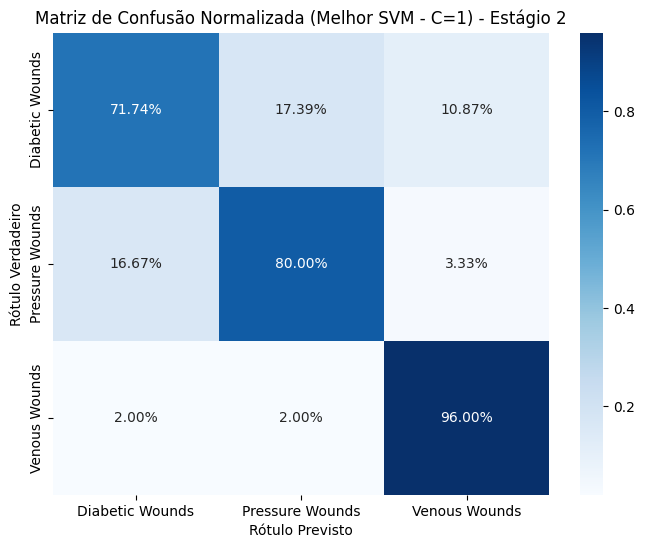


Classes do Estágio 2 e seus índices para referência:
Índice 0: Diabetic Wounds
Índice 1: Pressure Wounds
Índice 2: Venous Wounds


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

print("\n--- Treinando SVM nos Embeddings Pré-computados (Estágio 2) ---")

train_s2_path = "embeddings/train_s2_emb.pt"
val_s2_path = "embeddings/val_s2_emb.pt"
test_s2_path = "embeddings/test_s2_emb.pt"

classes_s2 = ['Diabetic Wounds', 'Pressure Wounds', 'Venous Wounds']
idx_to_label_s2 = {0: 'Diabetic Wounds', 1: 'Pressure Wounds', 2: 'Venous Wounds'}


# --- 1. Carregar os Embeddings e Rótulos Pré-computados ---
if not all(os.path.exists(p) for p in [train_s2_path, val_s2_path, test_s2_path]):
    print(f"Erro: Arquivos de embedding não encontrados. Verifique os caminhos:")
    print(f"Treino: {train_s2_path}")
    print(f"Validação: {val_s2_path}")
    print(f"Teste: {test_s2_path}")
else:
    print(f"Carregando embeddings de treino de: {train_s2_path}")
    train_embs, train_labels = torch.load(train_s2_path)
    print(f"Carregando embeddings de validação de: {val_s2_path}")
    val_embs, val_labels = torch.load(val_s2_path)
    print(f"Carregando embeddings de teste de: {test_s2_path}")
    test_embs, test_labels = torch.load(test_s2_path)

    X_train = train_embs.cpu().numpy()
    y_train = train_labels.cpu().numpy()
    X_val = val_embs.cpu().numpy()
    y_val = val_labels.cpu().numpy()
    X_test = test_embs.cpu().numpy()
    y_test = test_labels.cpu().numpy()

    print(f"Shape dos dados de treino: X={X_train.shape}, y={y_train.shape}")
    print(f"Shape dos dados de validação: X={X_val.shape}, y={y_val.shape}")
    print(f"Shape dos dados de teste: X={X_test.shape}, y={y_test.shape}")

    if X_train.shape[0] == 0 or X_val.shape[0] == 0 or X_test.shape[0] == 0:
        print("Dados de treino, validação ou teste vazios após o carregamento. Pulando treinamento e avaliação da SVM.")
    else:
        # --- 2. Testar diferentes valores de C usando o conjunto de VALIDAÇÃO ---

        C_values = [0.01, 0.1, 1, 10, 100]
        best_val_accuracy = -1.0
        best_C = None
        
        print("\nIniciando teste de diferentes valores de C no conjunto de VALIDAÇÃO para seleção...")

        for C_val in C_values:
            print(f"\nTreinando SVC com C = {C_val} no conjunto de TREINO...")
            svm_model = SVC(kernel='rbf', C=C_val, random_state=42, probability=True)
            svm_model.fit(X_train, y_train)

            y_val_pred = svm_model.predict(X_val)
            current_val_accuracy = accuracy_score(y_val, y_val_pred)
            
            print(f"Acurácia no conjunto de VALIDAÇÃO para C={C_val}: {current_val_accuracy:.4f}")

            if current_val_accuracy > best_val_accuracy:
                best_val_accuracy = current_val_accuracy
                best_C = C_val

        print("\nSeleção do parâmetro C concluída com base no conjunto de validação.")
        print(f"Melhor C encontrado: {best_C}")
        print(f"Melhor Acurácia de Validação: {best_val_accuracy:.4f}")

        # --- 3. Treinar o modelo FINAL com o melhor C no conjunto de TREINO COMPLETO ---
        print(f"\nTreinando o modelo SVM FINAL com o melhor C ({best_C}) no conjunto de TREINO...")
        final_svm_model = SVC(kernel='rbf', C=best_C, random_state=42, probability=True)
        final_svm_model.fit(X_train, y_train)
        print("Treinamento do modelo FINAL concluído.")


        # --- 4. Avaliar o Modelo FINAL no Conjunto de TESTE (APENAS AGORA) ---

        print("\nAvaliando o modelo FINAL SVM no conjunto de TESTE (avaliação imparcial)...")
        y_pred_test = final_svm_model.predict(X_test)
        y_pred_probs_test = final_svm_model.predict_proba(X_test)

        # --- Geração e Exibição das Métricas de Avaliação ---

        print("\nRelatório de Classificação - Conjunto de TESTE (Melhor SVM):")
        report_dict = classification_report(y_test, y_pred_test, target_names=classes_s2, output_dict=True, zero_division=0)
        print(classification_report(y_test, y_pred_test, target_names=classes_s2, zero_division=0))

        accuracy_test = accuracy_score(y_test, y_pred_test)
        print(f"\nAcurácia Geral no Conjunto de TESTE (Melhor SVM - C={best_C}): {accuracy_test:.4f}")

        # --- IMPRIMIR PRECISÃO, RECALL e F1-SCORE GERAIS (Weighted Avg) ---
        print("\nMétricas Gerais do Modelo SVM (Weighted Average):")
        print(f"   Precision: {report_dict['weighted avg']['precision']:.4f}")
        print(f"   Recall: {report_dict['weighted avg']['recall']:.4f}")
        print(f"   F1-score: {report_dict['weighted avg']['f1-score']:.4f}")

        # --- CALCULAR E IMPRIMIR AUC ---
        if len(np.unique(y_test)) > 1:
            try:
                auc_score_test = roc_auc_score(y_test, y_pred_probs_test, multi_class='ovr', average='weighted')
                print(f"   AUC (Weighted) do Modelo SVM: {auc_score_test:.4f}")
            except ValueError as e:
                print(f"   Não foi possível calcular o AUC: {e}. Isso pode ocorrer se houver apenas uma classe verdadeira nos dados de teste.")
        else:
            print("   Não foi possível calcular o AUC: Apenas uma classe verdadeira encontrada nos dados de teste.")

        print("\nCalculando Matriz de Confusão (Melhor SVM) no TESTE...")
        cm = confusion_matrix(y_test, y_pred_test, labels=range(len(classes_s2)))

        # --- Normaliza a Matriz de Confusão para Porcentagens ---
        row_sums = cm.sum(axis=1)
        cm_normalized = cm.astype('float') / (row_sums[:, np.newaxis] + 1e-9)


        # Visualiza a Matriz de Confusão Normalizada (Porcentagens)
        print("Visualizando Matriz de Confusão Normalizada (Melhor SVM, em %) no TESTE...")
        plt.figure(figsize=(8, 6))

        sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                            xticklabels=classes_s2, yticklabels=classes_s2)

        plt.xlabel('Rótulo Previsto')
        plt.ylabel('Rótulo Verdadeiro')
        plt.title(f'Matriz de Confusão Normalizada (Melhor SVM - C={best_C}) - Estágio 2')
        plt.show()
        
print(f"\nClasses do Estágio 2 e seus índices para referência:")
if 'idx_to_label_s2' in locals():
    for i, name in idx_to_label_s2.items():
        print(f"Índice {i}: {name}")
else:
    print("Mapeamento de índices para nomes de classes (Estágio 2):")
    for i, name in enumerate(classes_s2):
        print(f"Índice {i}: {name}")